In [22]:
def qaoa_circuit(params, **kwargs):
    depth = len(params) // 2
    gammas, alphas = params[:depth], params[depth:]

    for node in graph.nodes:
        qml.Hadamard(wires=node)

    for i in range(depth):
        qaoa_layer(gammas[i], alphas[i])

    return qml.probs(wires=graph.nodes)

Step 0: cost = -0.19434019644251002
Step 10: cost = -0.15956006563436925
Step 20: cost = -0.21238183117100962
Step 30: cost = -0.28299419000349746
Step 40: cost = -0.2891184230758959
Step 50: cost = -0.20752028213353016
Step 60: cost = -0.18993939017010428
Step 70: cost = -0.1576237891306385
Step 80: cost = -0.2105831139945206
Step 90: cost = -0.22544428636873082
MaxCut solution: 00110, value: 0.2579199285670564


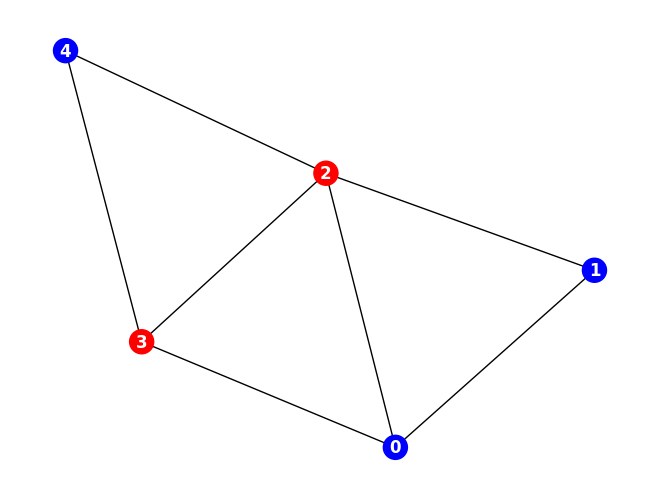

In [23]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Define the QAOA circuit

def qaoa_layer(gamma, alpha):
    for edge in graph.edges:
        qml.CNOT(wires=[edge[0], edge[1]])
        qml.RZ(2 * gamma, wires=edge[1])
        qml.CNOT(wires=[edge[0], edge[1]])
    for node in graph.nodes:
        qml.RX(2 * alpha, wires=node)

def qaoa_circuit(params, **kwargs):
    depth = len(params) // 2
    gammas, alphas = params[:depth], params[depth:]

    for node in graph.nodes:
        qml.Hadamard(wires=node)

    for i in range(depth):
        qaoa_layer(gammas[i], alphas[i])

    return qml.probs(wires=graph.nodes)


# Step 2: Define the graph for the MaxCut problem

edges = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (2, 4), (3, 4)]
graph = nx.Graph(edges)
num_nodes = len(graph.nodes)
num_edges = len(graph.edges)


# Step 3: Set up the device and QNode

dev = qml.device("default.qubit", wires=num_nodes)
qaoa = qml.QNode(qaoa_circuit, dev)


# Step 4: Define the cost function

def maxcut_cost(params):
    result = qaoa(params)
    state_probs = np.abs(result) ** 2
    maxcut_cost = 0
    for state_idx, prob in enumerate(state_probs):
        state = format(state_idx, f"0{num_nodes}b")
        cut_cost = sum(
            int(state[edge[0]]) != int(state[edge[1]])
            for edge in graph.edges
        )
        maxcut_cost += prob * cut_cost
    return -maxcut_cost


# Step 5: Optimize the parameters of the quantum circuit

init_params = np.random.uniform(0, np.pi, 2 * 2)  # Initial parameters (2 layers)
opt = qml.GradientDescentOptimizer(stepsize=0.3)
steps = 100

params = init_params
for i in range(steps):
    params = opt.step(maxcut_cost, params)
    if i % 10 == 0:
        cost = maxcut_cost(params)
        print(f"Step {i}: cost = {cost}")

# Step 6: Visualize the results

optimal_params = params
result = qaoa(optimal_params)
state_probs = np.abs(result) ** 2

maxcut_state_idx = np.argmax(state_probs)
maxcut_state = format(maxcut_state_idx, f"0{num_nodes}b")
maxcut_value = -maxcut_cost(optimal_params)

print(f"MaxCut solution: {maxcut_state}, value: {maxcut_value}")

colors = ["red" if maxcut_state[node] == "1" else "blue" for node in graph.nodes]
nx.draw(graph, with_labels=True, node_color=colors, font_weight="bold", font_color="white")
plt.show()

